In [ ]:
!rm -rf glo-flow

In [1]:
!git clone https://github.com/AlexanderNevarko/glo-flow.git

Cloning into 'glo-flow'...
remote: Enumerating objects: 226, done.
remote: Counting objects: 100% (226/226), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 226 (delta 130), reused 167 (delta 76), pack-reused 0
Receiving objects: 100% (226/226), 397.86 KiB | 3.13 MiB/s, done.
Resolving deltas: 100% (130/130), done.


In [2]:
import sys
sys.path.append('glo-flow/')
sys.path

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 'glo-flow/']

In [3]:
!pip install -q comet_ml

     |████████████████████████████████| 304 kB 4.4 MB/s 
     |████████████████████████████████| 54 kB 2.8 MB/s 
     |████████████████████████████████| 52 kB 1.3 MB/s 
     |████████████████████████████████| 546 kB 40.6 MB/s 


In [4]:
from comet_ml import Experiment
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from sklearn.manifold import TSNE
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

BW_METHOD = 0.1
N_COMPONENTS = 128

### Training the model

In [ ]:
# %load_ext autoreload
# %autoreload 2

In [5]:
from modules.glo import GLOGenerator, GLOModel, SampleGenerator
from modules.train import GLOTrainer, visualize_image_grid
from modules.dataset import IdxDataset
from modules.validate import Validator
from modules.loss import LapLoss

In [6]:
cifar_train = CIFAR10(root='datasets', train=True, transform=transforms.ToTensor(), download=True)
cifar_test = CIFAR10(root='datasets', train=False, transform=transforms.ToTensor(), download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting datasets/cifar-10-python.tar.gz to datasets
Files already downloaded and verified


In [7]:
cifar_train = IdxDataset(cifar_train)
cifar_test = IdxDataset(cifar_test)

In [8]:
idx = torch.randint(low=0, high=len(cifar_train), size=(128, ))
subset = torch.utils.data.Subset(cifar_train, idx)

In [9]:
train_loader = DataLoader(cifar_train, batch_size=32, shuffle=False)
val_loader = DataLoader(cifar_test, batch_size=32, shuffle=False)
subset_loader = DataLoader(subset, batch_size=16, shuffle=False)

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [11]:
generator = GLOGenerator(min_channels=64,
                         max_channels=1024,
                         noise_channels=N_COMPONENTS,
                         num_blocks=4,
                         dataloader=train_loader,
                         normalization='in').to(device)
sample_generator = SampleGenerator(train_loader, z_dim=N_COMPONENTS, bw_method=BW_METHOD)
model = GLOModel(generator, train_loader, sample_generator).to(device)

In [12]:
experiment = Experiment(api_key='CfFmqDpTCtsdDkLooedZh7bs2',
                        project_name='glo-cifar',
                        workspace='alexandernevarko')

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' and lookings in parents. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/alexandernevarko/glo-cifar/d05a615fcb374f708040774539f09873



In [13]:
trainer = GLOTrainer(model, use_gpu=True, logger=experiment)

In [16]:
zlr = 1e-3
gen_lr = 1e-3
loss_func = LapLoss(max_levels=3, channels=3, device=device)
g_optimizer = torch.optim.Adam([
    {'params': model.generator.parameters(), 'lr': gen_lr},
])
z_optimizer = torch.optim.Adam([
    {'params': model.z, 'lr': zlr}
])
# z_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(z_optimizer, mode='min', factor=0.2, 
#                                                          patience=5, threshold=3e-4, 
#                                                          threshold_mode='abs', verbose=True)
# g_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(generator_optimizer, mode='min', factor=0.2, 
#                                                          patience=7, threshold=3e-4, 
#                                                          threshold_mode='abs', verbose=True)
def zlr_factor(epoch):
    if epoch == 20:
        return 1/20
    else:
        return 1

def glr_factor(epoch):
    if epoch == 40:
        return 0.1
    else:
        return 1

z_scheduler = torch.optim.lr_scheduler.LambdaLR(z_optimizer, lr_lambda=zlr_factor)
g_scheduler = torch.optim.lr_scheduler.LambdaLR(g_optimizer, lr_lambda=glr_factor)

In [17]:
n_epochs = 300
exp_name = f'AdamSAdam_IN_Big_Lap_good_init_strat_2_zlr_1e2_glr_1e-3_{n_epochs}_epochs'
exp_name = 'SparseAdam_test'
trainer.train(n_epochs=n_epochs, train_loader=train_loader, 
              loss_func=loss_func, 
              generator_optimizer=g_optimizer, z_optimizer=z_optimizer,
              z_scheduler=None, generator_scheduler=None,
              exp_name=exp_name, model_path='')

  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.



Average epoch 0 loss: 0.08382519631052505


Average epoch 1 loss: 0.09663164740999158


Average epoch 2 loss: 0.09049258917875193


Average epoch 3 loss: 0.08849205100528719


KeyboardInterrupt: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp AdamAdam_test_zlr_1e-5_glr_1e-5_214+_epochs_model.pth /content/drive/MyDrive/GLANN/glo_cifar_models

In [ ]:
# model.load_state_dict(torch.load('/content/m/z_32_zlr_1e2_50_epochs_model.pth'))

<All keys matched successfully>

In [ ]:
model.eval()
z = nn.Parameter(torch.randn(size=(len(val_loader.dataset), N_COMPONENTS), device=device, requires_grad=True))
optimizer = torch.optim.SGD([z], lr=5e1)
loss_func = LapLoss(max_levels=3, channels=3, device=device)

validator = Validator(model, val_loader, loss_func, optimizer)

In [ ]:
z_new, loss = validator.validate(z=z, min_loss=0.06, max_iter=60)

In [ ]:
idx

tensor([47133, 37924,   422, 48750, 12943, 24647, 19253,   119, 34743, 14362,
         1482, 20819, 41526, 12953, 30018, 20005, 38670, 36934, 31489, 47035,
        41902,  7174, 49117,  2957, 18733, 27469, 13723, 44985,  8943, 21001,
        29081, 48324,  3277, 30615, 38722, 35816, 16473, 35287, 29811, 21266,
        32148, 30674, 19703, 35114, 48635, 38028, 49262, 20019,  6991, 24265,
        29235, 49453, 42783, 20727,  5024,  4762, 40243, 16389, 41940, 48487,
        44211, 35907, 26090, 19045, 49887, 34469,  1609, 10457, 49108, 46625,
        10716, 33757, 34767, 36709, 20651, 37416,  1394,  1421, 27653, 22584,
        49679, 36367,  2791, 48143, 13280, 40409, 42192, 27055, 34007,  7297,
         8862, 29313, 27461, 11423, 43989, 35939, 39780, 46187, 20200, 31252,
        10669,  2623, 24909, 12262, 39926, 37184, 27003, 45988, 36617, 12172,
        35615,  6549, 26866, 42895, 17868, 47012, 48317, 15723, 32829, 19858,
        46156, 22484, 38978, 10889, 24049,  2790, 15590,   205])

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.



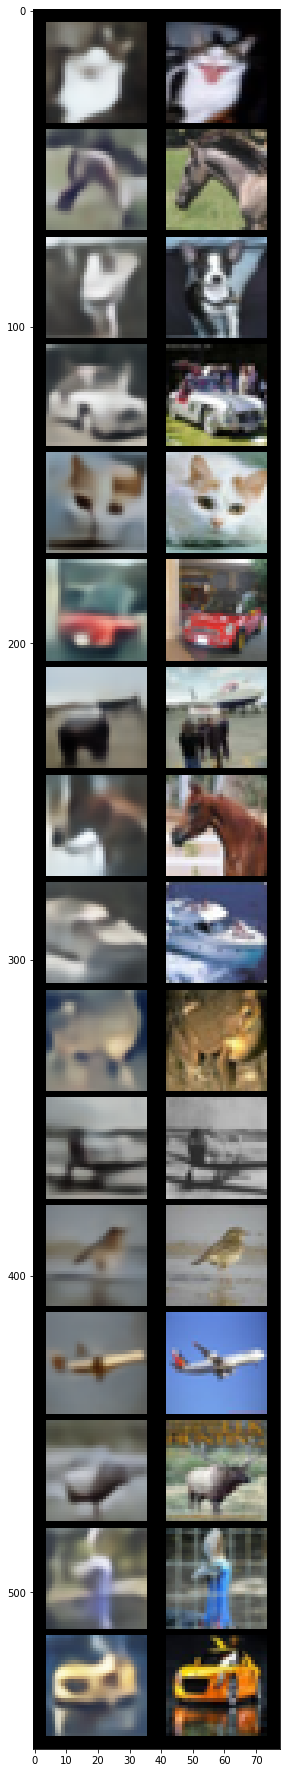

In [ ]:
N = 16
idx = torch.randint(low=0, high=len(model.z), size=(N, ))
img = []
for i in idx:
    img.append(train_loader.dataset[i][1])
img = torch.cat(img).view(N, 3, 32, 32)
res = validator.visualize_val_results(z=model.z[idx], img=img)
plt.figure(figsize=(12, 2*N))
plt.imshow(res)

In [ ]:
from modules.train import visualize_paired_results

ImportError: ignored

In [ ]:
!rm -rf glo-flow

In [ ]:
!cp Big_LapL1_z_128_zlr_1e0_25+++_epochs_cifar10_model.pth 

Now let's look at the model Z distribution!

In [ ]:
z_numpy = model.z.detach().cpu().numpy()

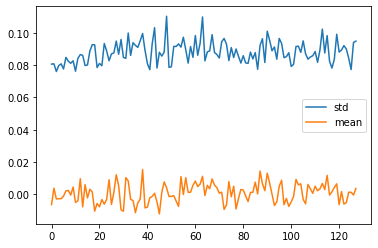

In [ ]:
plt.plot(z_numpy.std(axis=0), label='std')
plt.plot(z_numpy.mean(axis=0), label='mean')
plt.legend()

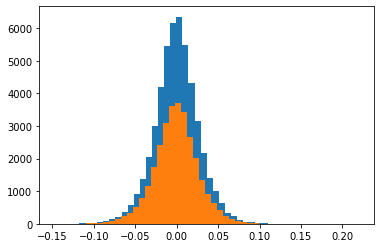

In [ ]:
i = -3
plt.hist(sample_generator.reproject_to_unit_ball(torch.tensor(sample_generator.z_dataset))[:, i], bins=50)
plt.hist(sample_generator.generate_samples(30_000).detach().numpy()[:, i], bins=50)
plt.show()

In [ ]:
X_embedded = TSNE(n_components=2).fit_transform(sample_generator.z_dataset[::100, :])

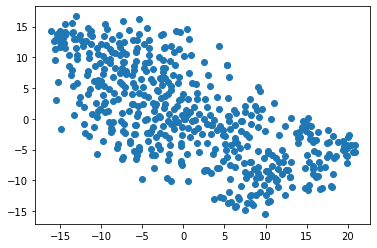

In [ ]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])

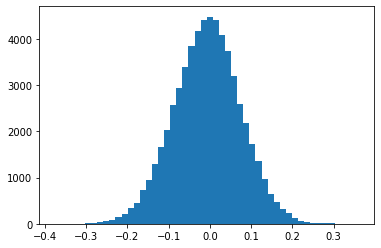

In [ ]:
_ = plt.hist(z_numpy[:, 0], bins=50)

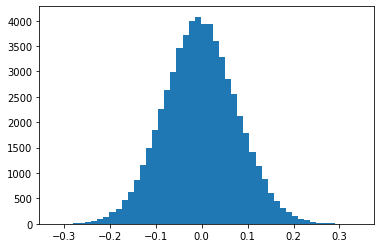

In [ ]:
_ = plt.hist(z_numpy[:, -10], bins=50)

In [ ]:
a = torch.tensor([1, 2, 3])
b = torch.tensor([0, 3, 5])
torch.amax(torch.vstack([a, b]), dim=0)

tensor([1, 3, 5])

In [ ]:
a.long()

tensor([1, 2, 3])

In [ ]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/alexandernevarko/glo-cifar/d85513e3b0754436b1a1564f08f3e05a
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Average epoch train loss [40] : (0.04634726129505624, 0.04803050831150948)
COMET INFO:     Average z-gradient [40]       : (6.477539864135906e-05, 0.00019693761714734137)
COMET INFO:     Train loss [62974]            : (0.036996133625507355, 0.059540484100580215)
COMET INFO:     loss [6298]                   : (0.037031855434179306, 0.058878060430288315)
COMET INFO:   Others:
COMET INFO:     Name : AdamAdam_test_zlr_1e-5_glr_1e-5_214+_epochs
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     images              : 40
COMET INFO:     installed packages  : 1
COMET INF